# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from scipy.stats import chi2_contingency
from scipy.stats import chi2

import re
import datetime
import numpy as np
import pandas as pd

import time

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Sparkify_Churn_Analysis") \
    .config("spark.network.timeout","3601") \
    .config("spark.executor.heartbeatInterval","3600") \
    .getOrCreate()

In [3]:
spark.conf.get("spark.executor.heartbeatInterval")

'3600'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json('medium-sparkify-event-data.json')
df.createOrReplaceTempView("log_table")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Let's first drop duplicates.

In [5]:
df = df.dropDuplicates()

and log entries from unregistered users

In [6]:
df = spark.sql(" SELECT * FROM log_table WHERE userID != '' ")

In [7]:
df.createOrReplaceTempView("log_table")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.



Let's look at the columns:

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Now let's see in which timeframe the data was collected:

In [9]:
ts_begin = spark.sql('SELECT MIN(ts) FROM log_table').first()[0]
ts_end = spark.sql('SELECT MAX(ts) FROM log_table').first()[0]
begin_datettime = datetime.datetime.fromtimestamp(ts_begin/1000)
end_datetime = datetime.datetime.fromtimestamp(ts_end/1000)
print('Data was collected between {} and {} over {} days.'.format(str(begin_datettime), str(end_datetime), (ts_end - ts_begin)//(24*3600000)))

Data was collected between 2018-10-01 02:00:11 and 2018-12-01 01:01:06 over 61 days.


In [10]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_date = udf(lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).date()))
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).weekday())
get_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).date().isocalendar()[1])

In [11]:
df = df.withColumn("date", get_date(df.ts))
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("weekday", get_weekday(df.ts))
df = df.withColumn("week", get_week(df.ts))

In [12]:
df.createOrReplaceTempView("log_table")
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', date='2018-10-01', hour='2', weekday='0', week='40')

## Issue analysis and business questions
In order to understand how churn is affecting Sparkify we will answer the following questions:
1. What are the usage statistics of Sparkify ?
2. What are the dynamics of business development?
3. Are there threats to the business?

### 1. Usage statistics of Sparkify
To answer this question let's look at the distribution of user activity and number of online users during the observation period. To get more detailed insights we will look at the statistics of active users and number of songs played each day, the mean for weekday and during the hours of the day.

#### Let's look at the number of songs played over the observation period and per weekday:

In [13]:
sql_request = 'SELECT count(ts) AS playcount, date, MIN(weekday) AS weekday, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY date'
playcount_days = spark.sql(sql_request).toPandas()
playcount_days = playcount_days[playcount_days['playcount']>10].sort_values(by = 'ts')

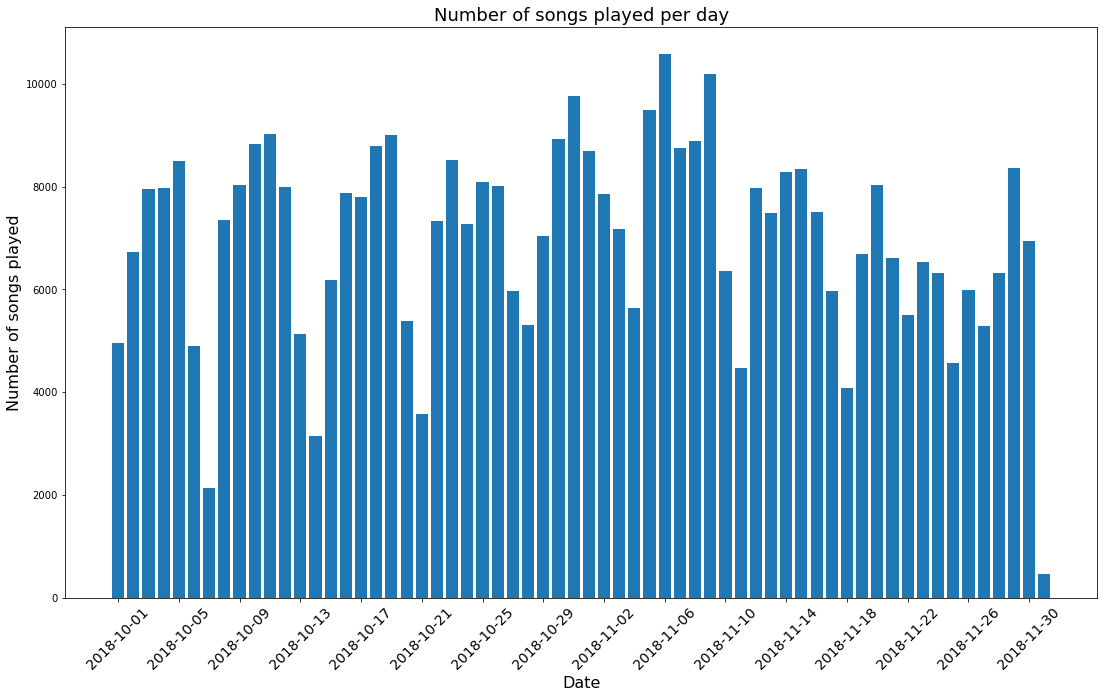

In [14]:
plt.bar(np.arange(0,62),playcount_days['playcount'])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,61,4), playcount_days['date'][::4], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played', fontsize = 16)
plt.title('Number of songs played per day', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

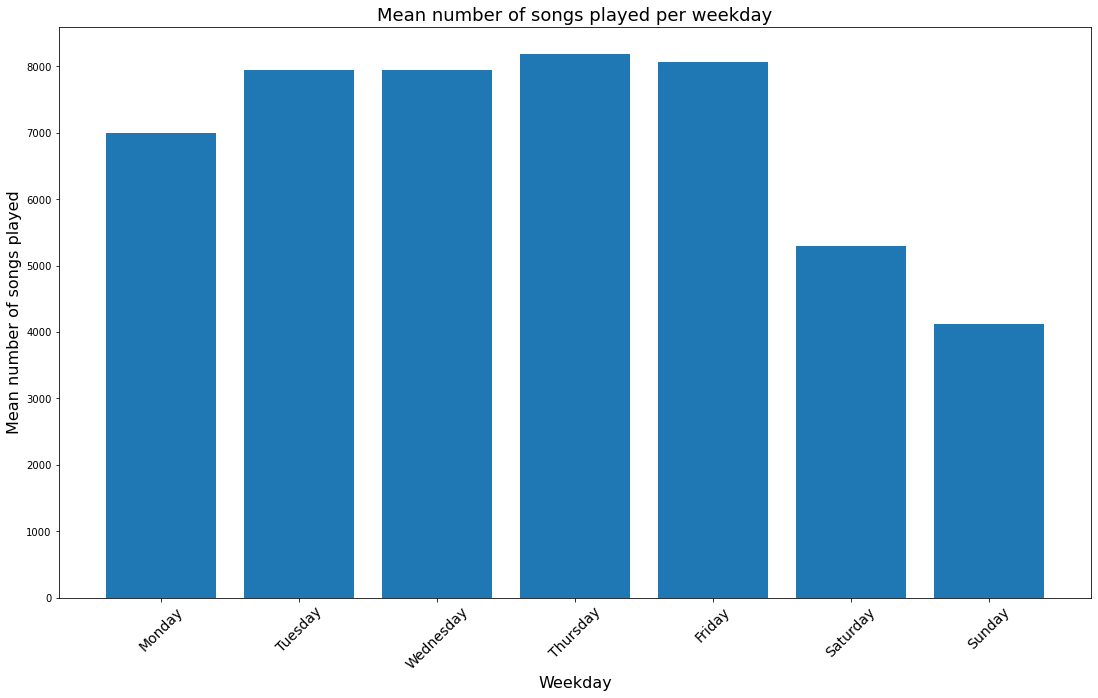

In [15]:
plt.bar(np.arange(0,7),playcount_days.groupby(['weekday'])['playcount'].mean())
plt.xlabel('Weekday', fontsize = 16)
plt.xticks(np.arange(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, fontsize = 14)
plt.ylabel('Mean number of songs played', fontsize = 16)
plt.title('Mean number of songs played per weekday', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Let's look at unique user count over the observation period and per weekday:

In [16]:
sql_request = 'SELECT count(DISTINCT userID) AS usercount, date, MIN(weekday) AS weekday, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY date'
usercount_days = spark.sql(sql_request).toPandas()
usercount_days = usercount_days[usercount_days['usercount']>10].sort_values(by = 'ts')

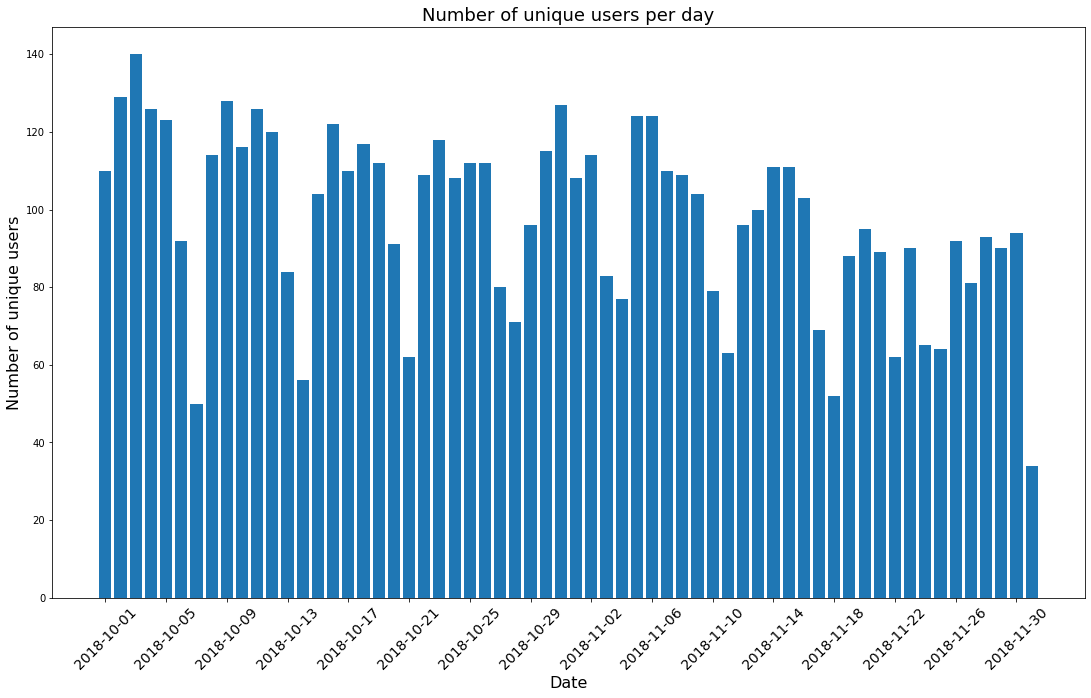

In [17]:
plt.bar(np.arange(0,62),usercount_days['usercount'])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,61,4), playcount_days['date'][::4], rotation=45, fontsize = 14)
plt.ylabel('Number of unique users', fontsize = 16)
plt.title('Number of unique users per day', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

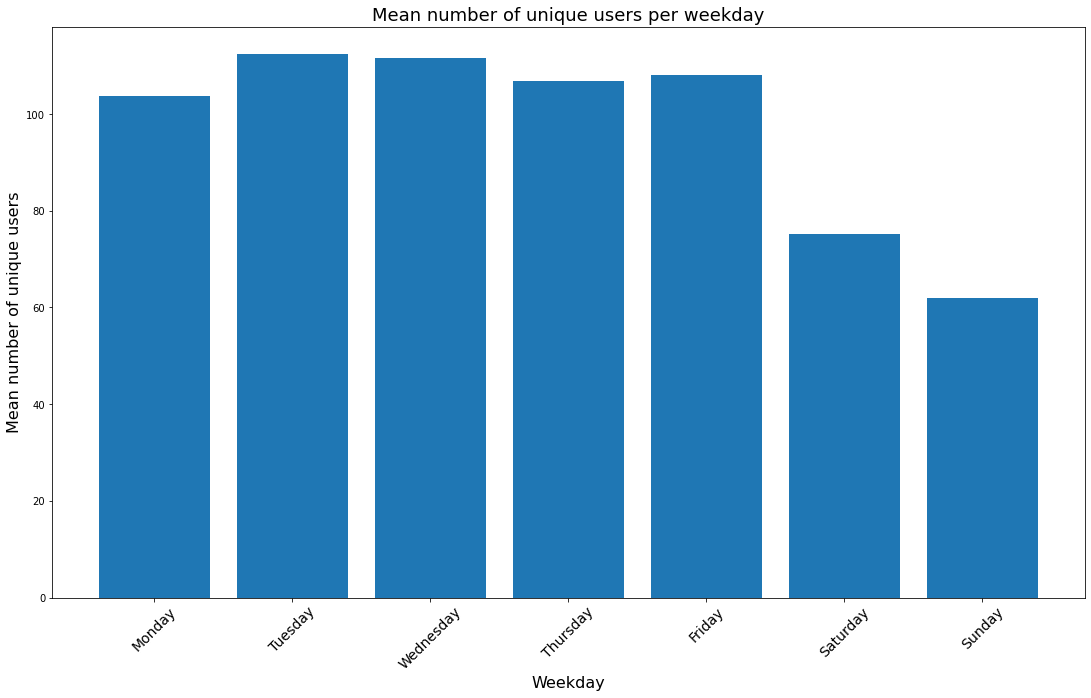

In [18]:
plt.bar(np.arange(0,7),usercount_days.groupby(['weekday'])['usercount'].mean())
plt.xlabel('Weekday', fontsize = 16)
plt.xticks(np.arange(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, fontsize = 14)
plt.ylabel('Mean number of unique users', fontsize = 16)
plt.title('Mean number of unique users per weekday', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Let's look at songs per user over the observation period and per weekday:

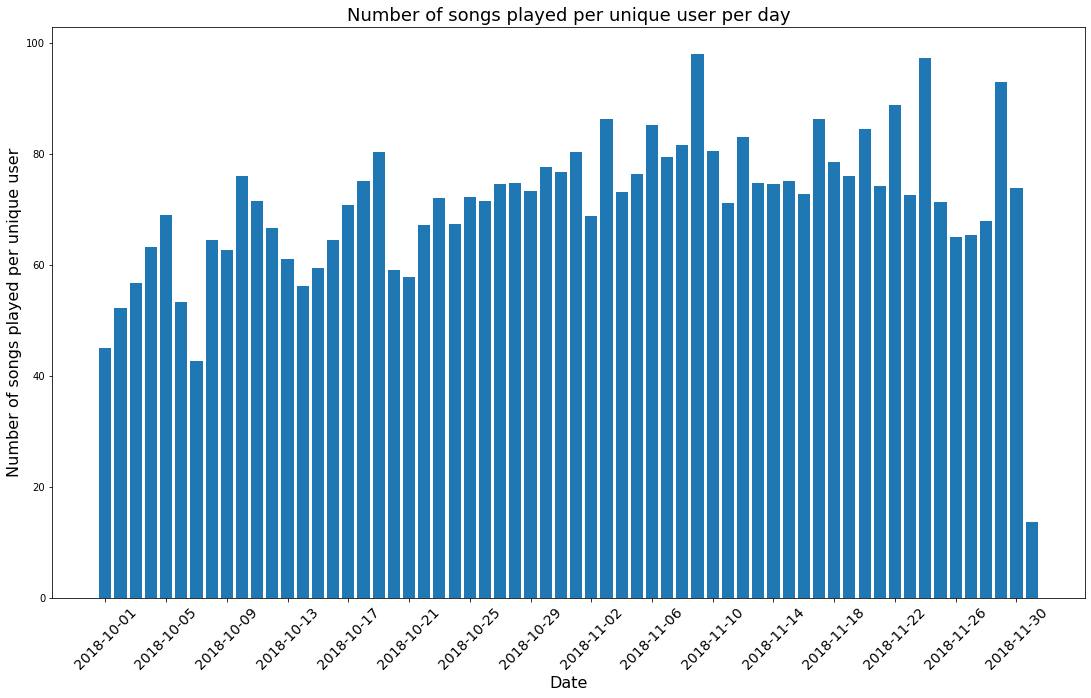

In [19]:
plt.bar(np.arange(0,62),playcount_days['playcount']/usercount_days['usercount'])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,61,4), playcount_days['date'][::4], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played per unique user', fontsize = 16)
plt.title('Number of songs played per unique user per day', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

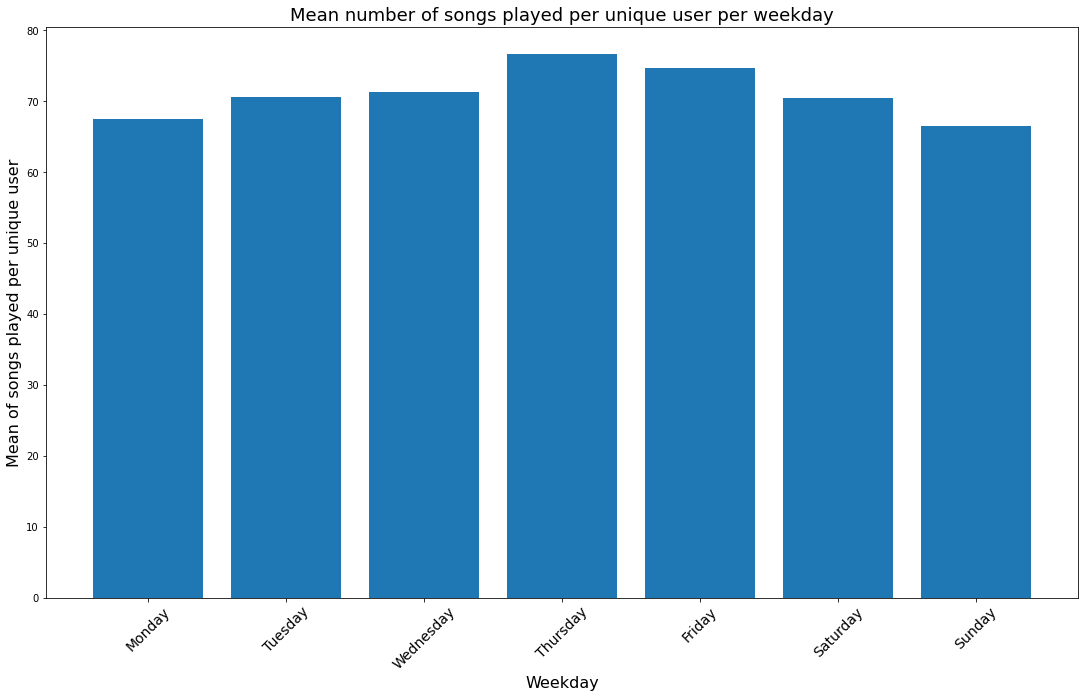

In [20]:
plt.bar(np.arange(0,7),playcount_days.groupby(['weekday'])['playcount'].mean()/usercount_days.groupby(['weekday'])['usercount'].mean())
plt.xlabel('Weekday', fontsize = 16)
plt.xticks(np.arange(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45, fontsize = 14)
plt.ylabel('Mean of songs played per unique user', fontsize = 16)
plt.title('Mean number of songs played per unique user per weekday', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#### Now let's look at the distribution of the user activity throughout the day.

In [21]:
sql_request = 'SELECT count(DISTINCT userID) AS usercount, count(DISTINCT date) AS daycount, hour, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY hour'
usercount_hour = spark.sql(sql_request).toPandas()
usercount_hour = usercount_hour.sort_values(by = 'ts')

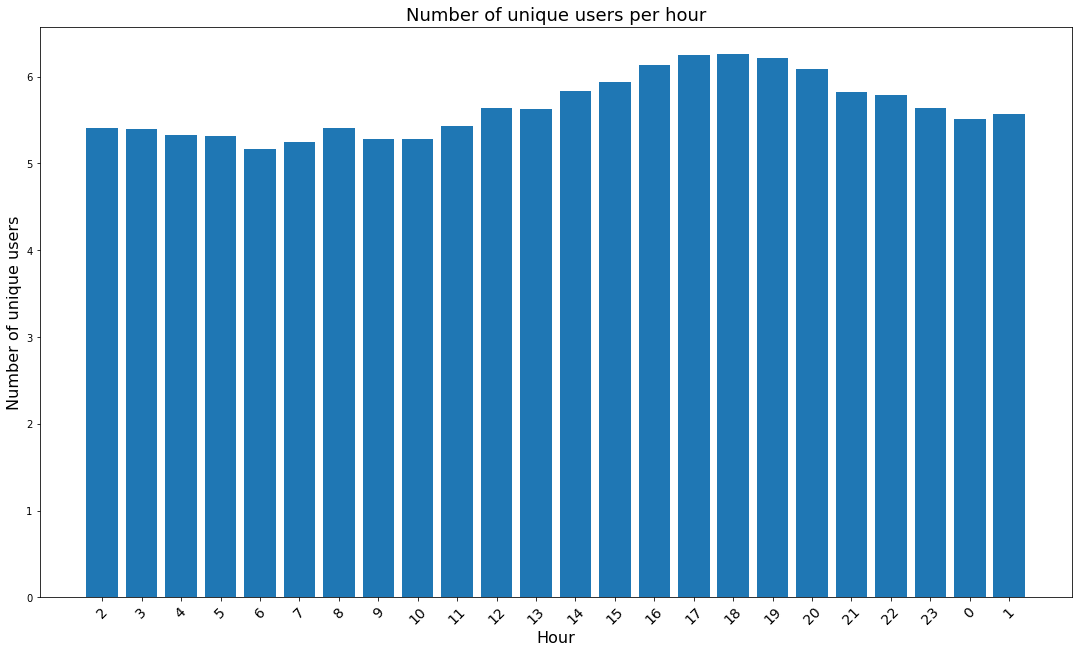

In [22]:
plt.bar(np.arange(0,24),usercount_hour['usercount']/usercount_hour['daycount'])
plt.xlabel('Hour', fontsize = 16)
plt.xticks(np.arange(0,24), usercount_hour['hour'], rotation=45, fontsize = 14)
plt.ylabel('Number of unique users', fontsize = 16)
plt.title('Number of unique users per hour', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [23]:
sql_request = 'SELECT count(DISTINCT ts) AS playcount, count(DISTINCT date) AS daycount, hour, MIN(ts) AS ts FROM log_table WHERE page = "NextSong" GROUP BY hour'
playcount_hour = spark.sql(sql_request).toPandas()
playcount_hour = playcount_hour.sort_values(by = 'ts')

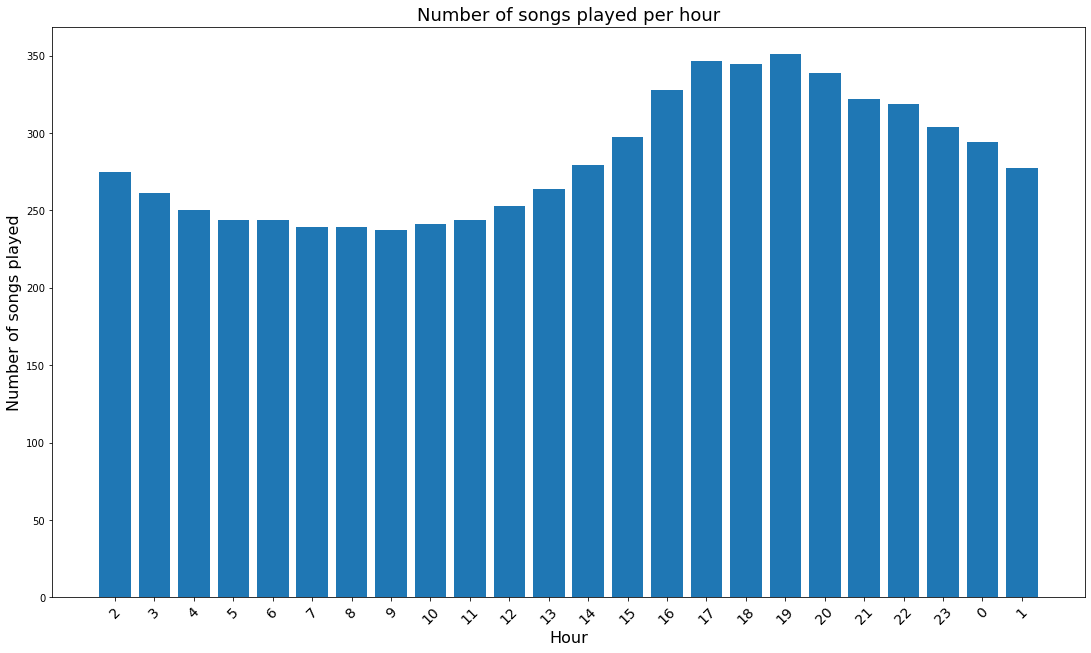

In [24]:
plt.bar(np.arange(0,24),playcount_hour['playcount']/usercount_hour['daycount'])
plt.xlabel('Hour', fontsize = 16)
plt.xticks(np.arange(0,24), playcount_hour['hour'], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played', fontsize = 16)
plt.title('Number of songs played per hour', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

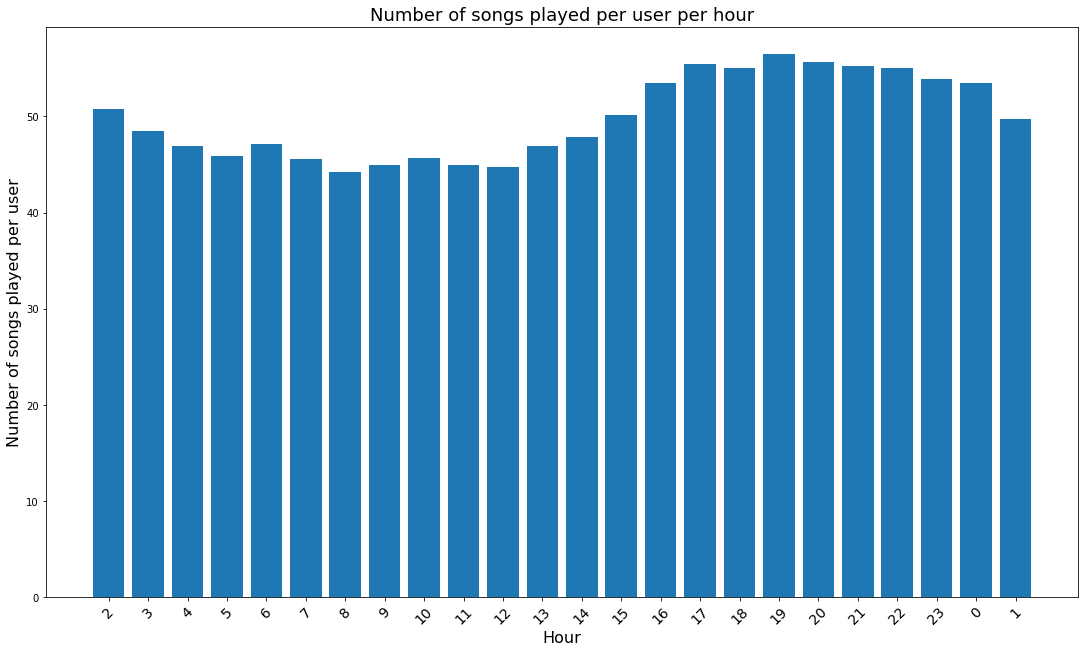

In [25]:
plt.bar(np.arange(0,24),playcount_hour['playcount']/usercount_hour['usercount'])
plt.xlabel('Hour', fontsize = 16)
plt.xticks(np.arange(0,24), playcount_hour['hour'], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played per user', fontsize = 16)
plt.title('Number of songs played per user per hour', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Summary for usage statistics

##### Let's formulate the key insights from our analysis:
* We have seen that usage statistics follow a weekly pattern with less users using Sparkify on weekends.
* Unsurprisingly there is a spike in streams around Helloween.
* Throughout the day the number of users remains almost constant with a slight increase between 1 and 7 p.m.
* The number of songs played per user throughout the day has a pattern where it follows daily activities: get up, way to work, start of work, lunchbreak etc.

##### More important is to know what we can do with this insights:
* We can optimise licence costs knowing how many songs will be played.
* We can optimise the number of servers running throughout the day and week to save electricity and networking costs based on user activity.
* We can target our user communication to the timeframes where they are most likely to use our service.

### 2. Business development

As a streaming service Sparkify has two main sources of income:
1. Paying customers
2. Advertising

Let's look how many paying customers we have throughout the observation period and how many ads were displayed.

In [26]:
sql_request = 'SELECT count(DISTINCT userID) AS paidcount, week, MIN(ts) AS ts FROM log_table WHERE level = "paid" GROUP BY week'
paid_week = spark.sql(sql_request).toPandas()
paid_week = paid_week[paid_week['paidcount']>1].sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT userID) AS freecount, week, MIN(ts) AS ts FROM log_table WHERE level = "free" GROUP BY week'
free_week = spark.sql(sql_request).toPandas()
free_week = free_week[free_week['freecount']>1].sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT ts) AS adscount, week, MIN(ts) AS ts FROM log_table WHERE page = "Roll Advert" GROUP BY week'
ads_week = spark.sql(sql_request).toPandas()
ads_week = ads_week.sort_values(by = 'ts')

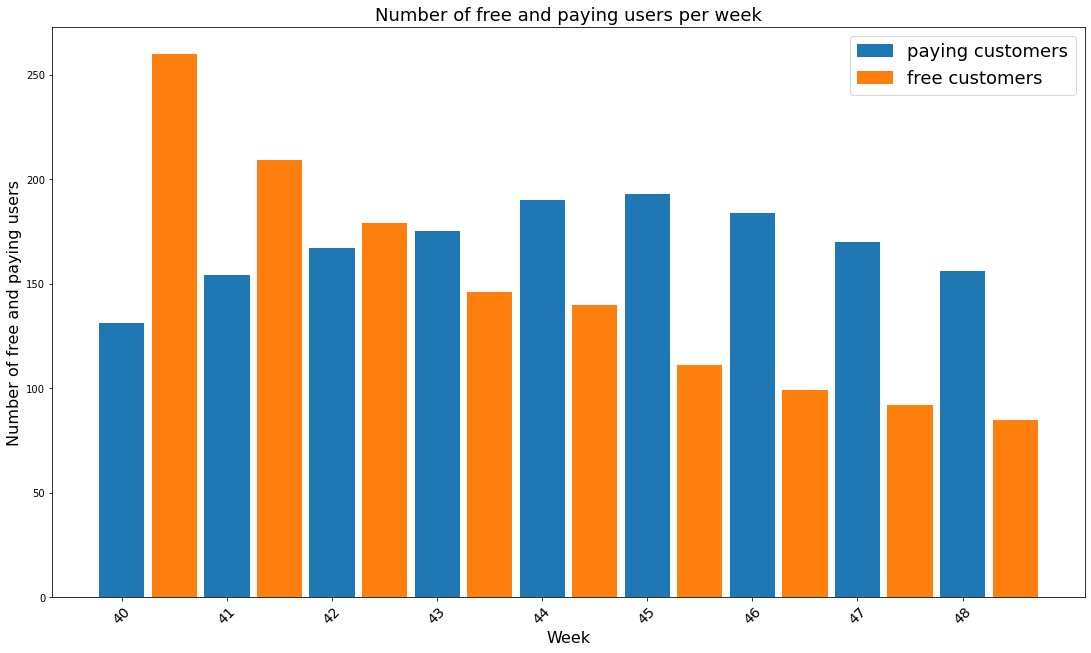

In [27]:
plt.bar(np.arange(0,9),paid_week['paidcount'], width = 0.43, label = 'paying customers')
plt.bar(np.arange(0,9) + 0.5,free_week['freecount'], width = 0.43, label = 'free customers')
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), ads_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of free and paying users', fontsize = 16)
plt.title('Number of free and paying users per week', fontsize = 18)
plt.legend(fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

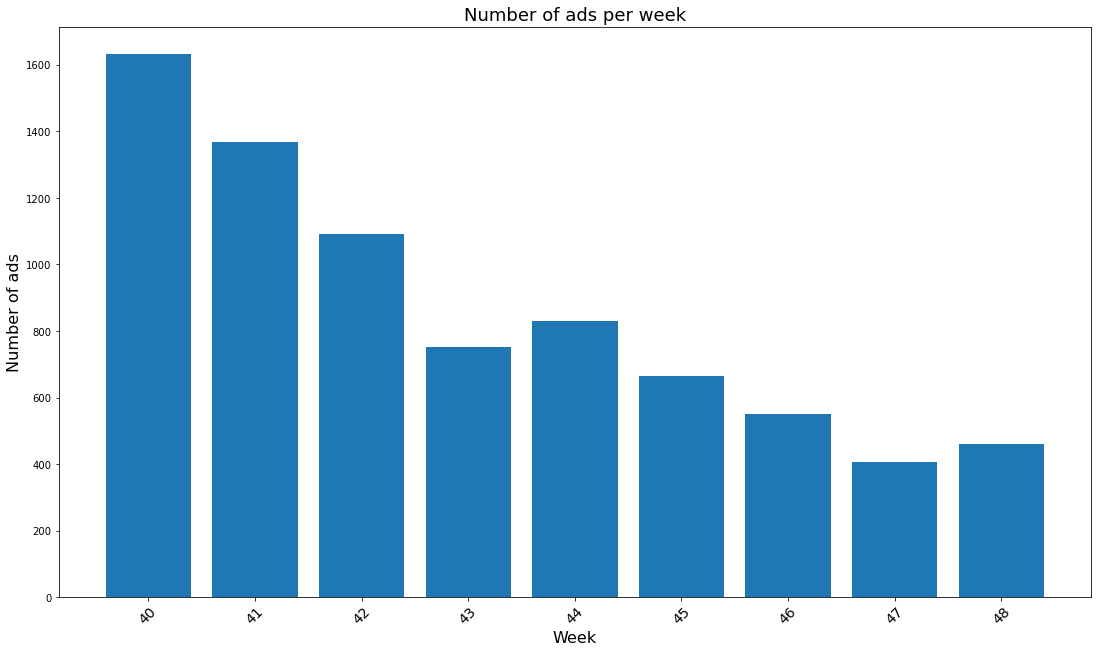

In [28]:
plt.bar(np.arange(0,9),ads_week['adscount'])
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), ads_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of ads', fontsize = 16)
plt.title('Number of ads per week', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

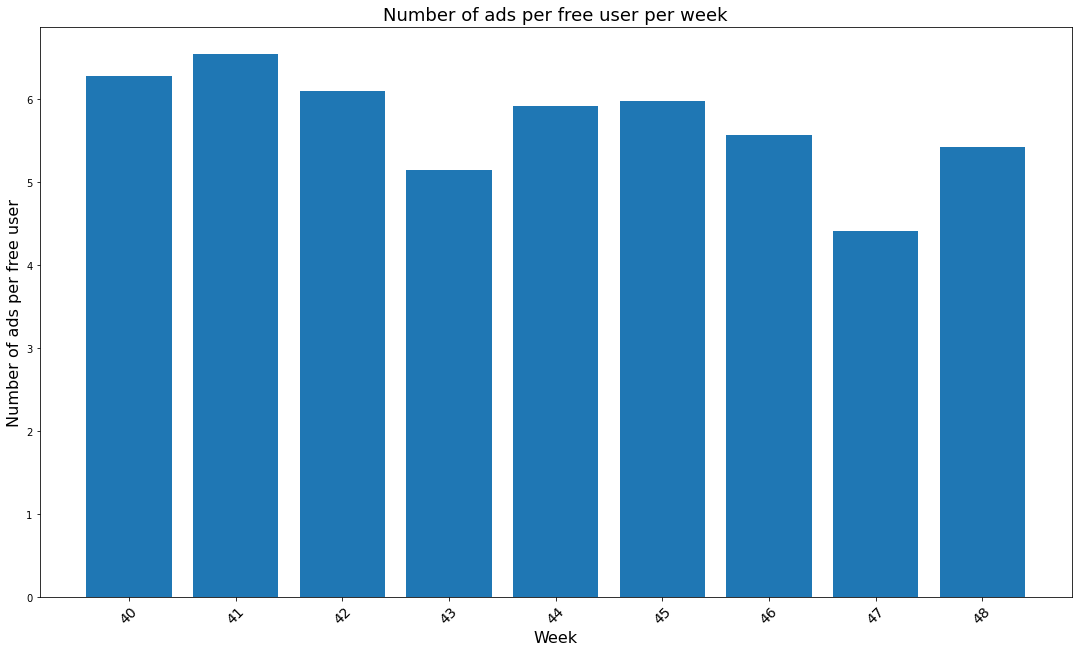

In [29]:
plt.bar(np.arange(0,9),ads_week['adscount']/free_week['freecount'])
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), ads_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of ads per free user', fontsize = 16)
plt.title('Number of ads per free user per week', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Summary
Let's formulate the key insights and takeaways for our business.

##### Key insights
* The number of paying customers is increasing in the observation period.
* The number of adverts decreases.
* The number of free customers is decreasing.

##### Takeaways for business
* The number of paying customers is not changing much after the first week. Probably we need to motivate people to switch to paid account by limited time offer or free trial.
* The number of free customers is decreasing at quite high rate. It seems that the free account is not very attractive. We have to look at the reasons more closely. Are the adverts to frequent? Do free users have limited access to the music titles?
* Although the number of adverts is falling the number of adverts per user is increasing. Perhaps we have taken the wrong road here given that free users are probably choosing to leave the service over upgrading their account?

### 3. Threats to the business
Now let's look at at the dynamics of the weekly numbers of account up- and downgrades as well as cancellations. To clarify if our business development goes the right way.

In [30]:
sql_request = 'SELECT count(DISTINCT userID) AS upgradecount, week, MIN(ts) AS ts FROM log_table WHERE page = "Submit Upgrade" GROUP BY week'
upgrades_week = spark.sql(sql_request).toPandas()
upgrades_week = upgrades_week.sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT userID) AS downgradecount, week, MIN(ts) AS ts FROM log_table WHERE page = "Submit Downgrade" GROUP BY week'
downgrades_week = spark.sql(sql_request).toPandas()
downgrades_week = downgrades_week.sort_values(by = 'ts')
sql_request = 'SELECT count(DISTINCT userID) AS cancellationscount, week, MIN(ts) AS ts FROM log_table WHERE page = "Cancellation Confirmation" GROUP BY week'
cancellations_week = spark.sql(sql_request).toPandas()
cancellations_week = cancellations_week.sort_values(by = 'ts')

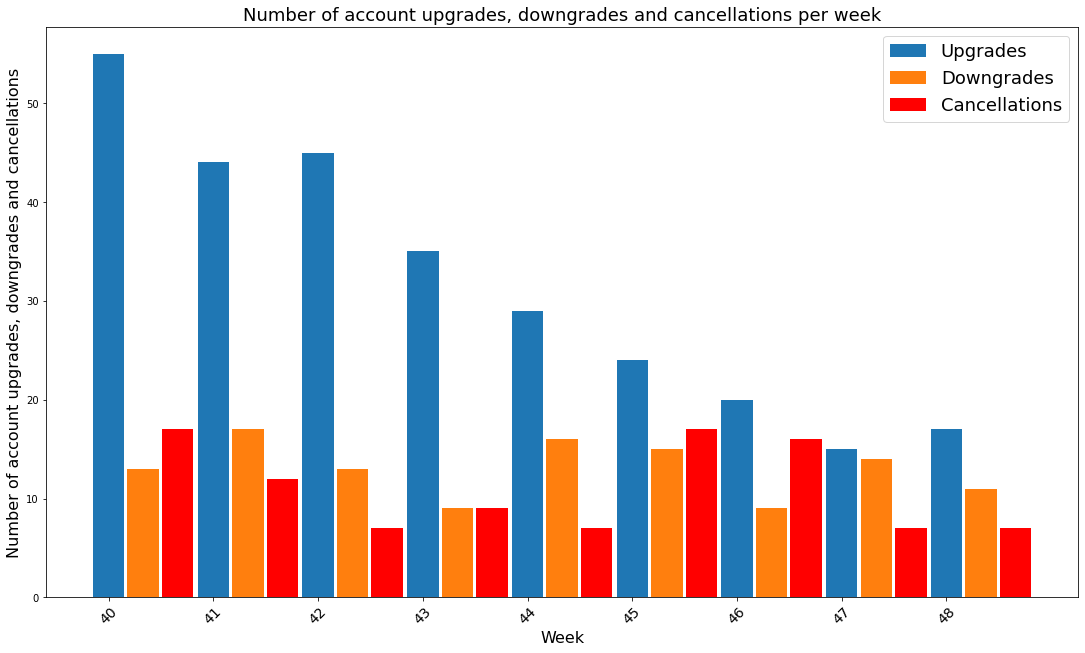

In [31]:
plt.bar(np.arange(0,9),upgrades_week['upgradecount'], width = 0.3, label = 'Upgrades')
plt.bar(np.arange(0,9) + 0.33,downgrades_week['downgradecount'], width = 0.3, label = 'Downgrades')
plt.bar(np.arange(0,9) + 0.66,cancellations_week['cancellationscount'], width = 0.3, label = 'Cancellations', color = 'red')
plt.xlabel('Week', fontsize = 16)
plt.xticks(np.arange(0,9), upgrades_week['week'], rotation=45, fontsize = 14)
plt.ylabel('Number of account upgrades, downgrades and cancellations', fontsize = 16)
plt.title('Number of account upgrades, downgrades and cancellations per week', fontsize = 18)
plt.legend(fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [32]:
cancellations = spark.sql('''SELECT level, count(DISTINCT userID) AS number_cancelled \
        FROM log_table WHERE page = "Cancellation Confirmation" GROUP BY level''').toPandas()

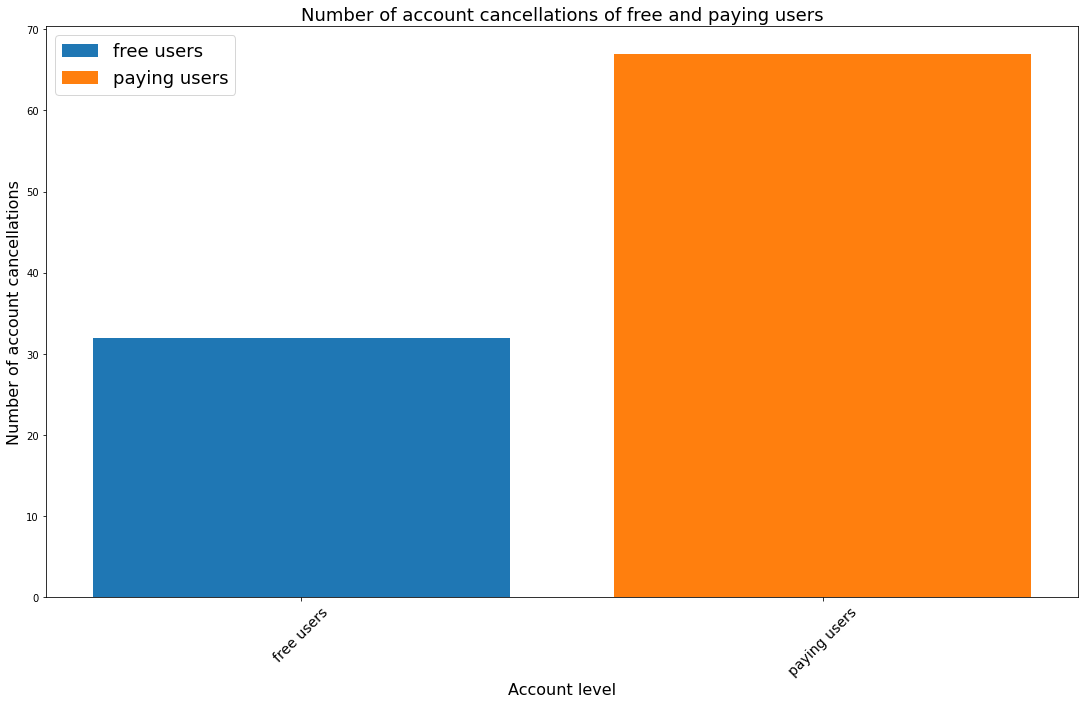

In [33]:
plt.bar([0],cancellations['number_cancelled'][0], label = 'free users')
plt.bar([1],cancellations['number_cancelled'][1], label = 'paying users')
plt.xlabel('Account level', fontsize = 16)
plt.xticks([0, 1], ['free users', 'paying users'], rotation=45, fontsize = 14)
plt.ylabel('Number of account cancellations', fontsize = 16)
plt.title('Number of account cancellations of free and paying users', fontsize = 18)
plt.legend(fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Summary
Let's formulate the key insights and takeaways for our business.

##### Key insights
* The number of upgrades spiked in the first week of observation.
* The number of upgrades is declining during the period of observation.
* The number of downgrades has a small spike in the week 41 and is almost steady with decline near the end.
* The number of cancellations is almost steady with a small spike around week 42 and decline near the end.
* Paying users are cancelling their accounts more often then free users.

##### Takeaways for business
* Whatever we have done in the week 40 we must keep doing that!
* We need to understand why less and less customers choose to upgrade their accounts.
* Although the downgrade and cancellation rates are falling we need pay more attention to them.
* The fact that paying users are choosing to cancel their account rather than to downgrade them is alarming.

##### How are we making paying customers angry?
Do they actually get to hear ads after they upgraded their accounts?

In [34]:
sql_request = 'SELECT level AS Account_Level, COUNT(level) AS Advert_Count, COUNT(DISTINCT userID) as Customer_Count \
                FROM log_table WHERE page = "Roll Advert" GROUP BY level'
ads_level = spark.sql(sql_request).toPandas()

In [35]:
ads_level

,Account_Level,Advert_Count,Customer_Count
0,free,7337,349
1,paid,436,167


## Hypothesis testing

Two hypothesis were assumed to be true in the previous sections:
1. Customers with paid level accounts are more likely to cancel their accounts than customers with free account level.
2. Paid customers, who have seen adverts are more likely to cancel their accounts, than paid customers, who haven't seen adverts.

Let's use statistics to test this hypothesese. First let's start by formulating the hypothesese:
1. Hypothesese about account level and account cancellation.
  * Null hypothesis: account level and and account cancellations are statistically independent.
  * Alternative hypothesis: account level has positive correlation with account cancellation.
2. Hypothesese about paid account level and adverts.
  * Null hypothesis: paid account level cancellation and seeing ads as paid account level customer are statistically independent.
  * Alternative hypothesis:  paid account level cancellation has positive correlation with seeing ads as paid account level customer.
  
Let's apply $\chi^2$ (chi-squared) test to these hypothesese. To learn more about the methodology you can read this [article by Jason Brownlee](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/)

### Testing the 1. Hypothesis
First we will create [contigency table](https://en.wikipedia.org/wiki/Contingency_table) for the first hypothesis using SQL request:

In [36]:
sql_request = '''SELECT userID, COUNT(DISTINCT level) AS level_count, MAX(level) AS max_level, \
        SUM(CASE page WHEN "Cancellation Confirmation" THEN 1 ELSE 0 END) cancelled,\
        SUM(CASE page WHEN "Submit Downgrade" THEN 1 ELSE 0 END) downgrade,\
        SUM(CASE page WHEN "Submit Upgrade" THEN 1 ELSE 0 END) upgrade\
        FROM log_table GROUP BY userID'''
df_1 = spark.sql(sql_request).toPandas()

In [37]:
df_churn = df_1.groupby('max_level').agg({'level_count':['mean','max'],
                                'cancelled':'sum',
                                'downgrade':['mean','max'],
                                'upgrade':['mean','max'],
                                'userID':'count'})
df_churn['not_cancelled'] = df_churn.userID['count'] - df_churn.cancelled['sum']
df_churn

level_count     cancelled downgrade       upgrade     userID  \
                 mean max       sum      mean max      mean max  count   
max_level                                                                
free         1.000000   1        24  0.000000   0  0.000000   0    127   
paid         1.757009   2        75  0.364486   3  0.894081   3    321   

          not_cancelled  
                         
max_level                
free                103  
paid                246

In [38]:
df_churn_contigency = pd.DataFrame()
df_churn_contigency['cancelled'] = df_churn['cancelled']['sum']
df_churn_contigency['not_cancelled'] = df_churn['not_cancelled']
df_churn_contigency

,cancelled,not_cancelled
free,24,103
paid,75,246


In [39]:
def pearson_chi2_test(df, prob):
    stat, p, dof, expected = chi2_contingency(df)
    print('dof=%d' % dof)
    print(expected)
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

In [40]:
pearson_chi2_test(df_churn_contigency, 0.95)

dof=1
[[ 28.06473214  98.93526786]
 [ 70.93526786 250.06473214]]
probability=0.950, critical=3.841, stat=0.811
Independent (fail to reject H0)
significance=0.050, p=0.368
Independent (fail to reject H0)


#### Conclusion:
* the first hypothesis is rejected in favor of the null hypothesis based on 0.05 significance level.

Let's test if there are other dependencies. For example to the number of account downgrades.

In [42]:
df_downgrade = df_1.groupby('downgrade').agg({'level_count':['mean','max'],
                                'cancelled':'sum',
                                'userID':'count'})
df_downgrade

level_count     cancelled userID
                 mean max       sum  count
downgrade                                 
0            1.415954   2        78    351
1            2.000000   2        14     78
2            2.000000   2         6     18
3            2.000000   2         1      1

In [43]:
df_downgrade['not_cancelled'] = df_downgrade.userID['count'] - df_downgrade.cancelled['sum']
df_downgrade_contigency = pd.DataFrame()
df_downgrade_contigency['cancelled'] = df_downgrade['cancelled']['sum']
df_downgrade_contigency['not_cancelled'] = df_downgrade['not_cancelled']
df_downgrade_contigency

,cancelled,not_cancelled
0,78,273
1,14,64
2,6,12
3,1,0


In [44]:
pearson_chi2_test(df_downgrade_contigency, 0.95)

dof=3
[[7.75647321e+01 2.73435268e+02]
 [1.72366071e+01 6.07633929e+01]
 [3.97767857e+00 1.40223214e+01]
 [2.20982143e-01 7.79017857e-01]]
probability=0.950, critical=7.815, stat=5.628
Independent (fail to reject H0)
significance=0.050, p=0.131
Independent (fail to reject H0)


There is also no dependency between downgrade and cancellation at 0.05 significance level.

### Testing the 2. hypothesis.

In [45]:
sql_request = '''SELECT userId, \
        SUM(CASE page WHEN "Cancellation Confirmation" THEN 1 ELSE 0 END) cancelled,\
        SUM(CASE page WHEN "Roll Advert" THEN 1 ELSE 0 END) ad_count,\
        SUM(CASE page WHEN "Submit Downgrade" THEN 1 ELSE 0 END) downgrade\
        FROM log_table WHERE level = "paid" GROUP BY userId'''
df_2 = spark.sql(sql_request).toPandas()

In [46]:
df_2.ad_count = df_2.ad_count > 0
df_ads = df_2.groupby('ad_count').agg({'userId':'count', 'cancelled':'sum'})
df_ads

,userId,cancelled
ad_count,,
False,154,28
True,167,39


In [47]:
pearson_chi2_test(df_ads, 0.95)

dof=1
[[150.57216495  31.42783505]
 [170.42783505  35.57216495]]
probability=0.950, critical=3.841, stat=0.621
Independent (fail to reject H0)
significance=0.050, p=0.431
Independent (fail to reject H0)


#### Conclusion: the second hypothesis has to be rejected as well.

## Explorative Data Analysis

This function will give an overview of distinct value counts and their distribution if the number of distinct values is smaller than 20.

In [48]:
def show_distinct_counts(column_name, table_name = 'log_table'):
    """Shows counts of distinct values of a column in an sql table.
    If the number of distinct values is smaller than 20 then
    counts for each value are displayed. Otherwise only the total
    number of distinct values is presented.
    
    INPUT:
        column_name (str): name of the column
        table_name (str): name of the table
        
    OUTPUT:
        none
    """
    n_distinct = spark.sql('SELECT COUNT(DISTINCT {}) AS count FROM {}'.format(column_name, table_name)).first()[0]
    #print(n_distinct)
    
    if n_distinct<=20:
        sql_query = 'SELECT {0}, count({0}) AS {0}_counts FROM {1} GROUP BY {0}'.format(column_name, table_name)
    else:
        sql_query = 'SELECT COUNT(DISTINCT {0}) AS Distinct_count_{0} FROM {1}'.format(column_name, table_name)
        
    spark.sql(sql_query).show()   

Let's apply this function to the dataframe's columns to get an overview of the data:

In [49]:
for column in df.columns:
    show_distinct_counts(column)

+---------------------+
|Distinct_count_artist|
+---------------------+
|                21247|
+---------------------+

+---------+-----------+
|     auth|auth_counts|
+---------+-----------+
|Cancelled|         99|
|Logged In|     527906|
+---------+-----------+

+------------------------+
|Distinct_count_firstName|
+------------------------+
|                     345|
+------------------------+

+------+-------------+
|gender|gender_counts|
+------+-------------+
|     F|       225393|
|     M|       302612|
+------+-------------+

+----------------------------+
|Distinct_count_itemInSession|
+----------------------------+
|                        1006|
+----------------------------+

+-----------------------+
|Distinct_count_lastName|
+-----------------------+
|                    275|
+-----------------------+

+---------------------+
|Distinct_count_length|
+---------------------+
|                16679|
+---------------------+

+-----+------------+
|level|level_counts|
+-----+--

This method didn't provide the results we wanted for gender and level. Let's do some extra evaluation for these columns.

First let's look at the gender distribution:

In [50]:
spark.sql(''' SELECT gender, count(DISTINCT userID) AS gender_counts FROM log_table GROUP BY gender ''').show()

+------+-------------+
|gender|gender_counts|
+------+-------------+
|     F|          198|
|     M|          250|
+------+-------------+



Let's see how many users changed their level:

In [51]:
spark.sql(''' SELECT levels AS level_counts, count(levels) AS users \
        FROM (SELECT count(DISTINCT level) AS levels \
        FROM log_table GROUP BY userID) GROUP BY levels ''').show()

+------------+-----+
|level_counts|users|
+------------+-----+
|           1|  205|
|           2|  243|
+------------+-----+



And how many users get their subscription cancelled:

In [52]:
spark.sql(''' SELECT auth, count(DISTINCT userID) AS auth_counts FROM log_table GROUP BY auth ''').show()

+---------+-----------+
|     auth|auth_counts|
+---------+-----------+
|Cancelled|         99|
|Logged In|        448|
+---------+-----------+



### The suggestion was to define churn as following events:
1. Customer cancelled account.
2. Customer downgraded account.

The first case is easier to track. Since the number of cancelled auth and visits to "Cancellation Confirmation" page is same, we can assume, that after visiting the page and getting the cancelled auth the users have cancelled their accounts.

The second case is more complicated and ambiguous, because the user behaviour of someone who downgraded their account may not be different from that of a paying user.They may choose to downgrade because they don't use the service frequently or just don't have the financial ability to pay for higher level service. Also let's keep in mind that we still generate revenue from free level users by rolling ads.

### In this notebook we define churn as account cancellation.

In [53]:
get_churn_cancel = udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
df = df.withColumn('churn_cancelled', get_churn_cancel('page'))
df.createOrReplaceTempView("log_table")

### Outliers

#### Early churn
If a user cancelled account in a timeframe less than a five days from beginning of observations we are dealing with early churn. In this case this user's data will not be compareable to others.

In [54]:
# let's find early churn users:
early_churn = spark.sql(''' SELECT userID, ts FROM log_table WHERE churn_cancelled = 1 ''').toPandas()
early_churn.sort_values('ts', inplace = True)
early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
early_churn = early_churn[early_churn['ts'] < ts_begin + 3600*24*5*1000]
list_remove = early_churn.userID.tolist()

#### Non-use
Some customers have very low interaction level. It is possible that they do not use the service at all. Keeping them in the analysis will skew the distribution of our features. We will assume that users with less than one interaction per day on average are effectively not using our service.

In [55]:
usage_statistic = spark.sql(''' SELECT userID, count(ts) AS interactions, MAX(churn_cancelled) AS churn FROM log_table GROUP BY userID ''').toPandas()

No handles with labels found to put in legend.


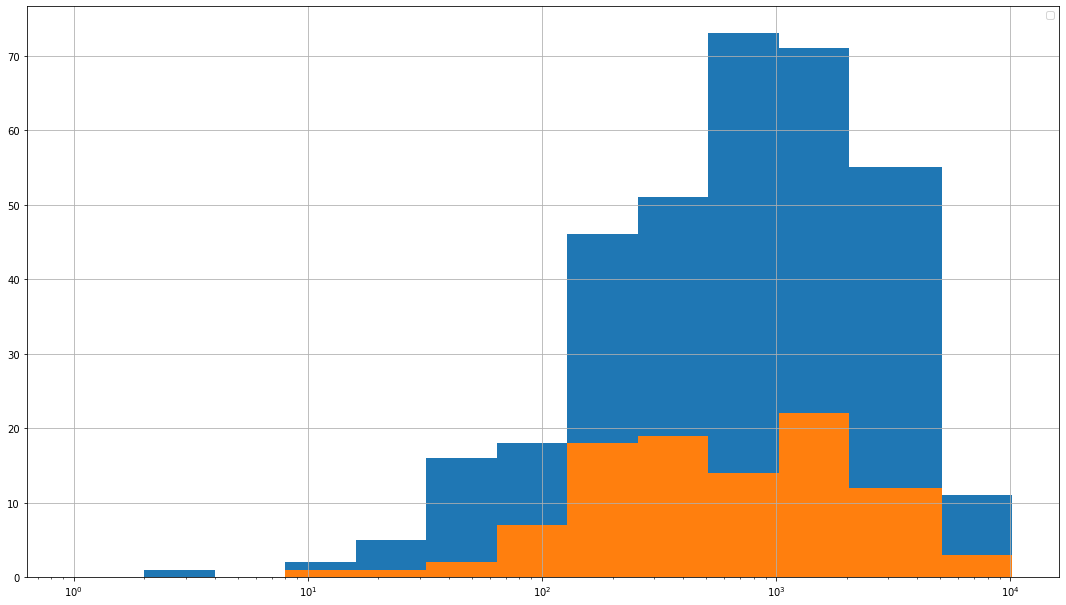

In [56]:
usage_statistic.groupby('churn')['interactions'].hist(bins = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 5096, 10192])
plt.xscale('log')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [57]:
non_users = usage_statistic[usage_statistic['interactions']<60].userID.tolist()
list_remove.extend([x for x in non_users if not x in list_remove])

In [58]:
print('We will have to remove {} users from our analysis due to early churn or low number of interactions.'.format(len(list_remove)))
print('User IDs: ', ' '.join(list_remove))

We will have to remove 36 users from our analysis due to early churn or low number of interactions.
User IDs:  208 231 100001 100013 236 100030 156 100032 100044 100036 271 200016 64 3 133 8 267 200035 177 200048 297 176 115 200033 300037 200031 300003 266 300026 200044 63 200012 123 300043 137 200049


In [62]:
import os

os.system('jupyter nbconvert --to html Sparkify_Wrangling_Statistics.ipynb')

0